In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

dftrain = pd.read_csv(r"archive\Train_data.csv")
dftest = pd.read_csv(r"archive\Test_data.csv")
print(f"Sum of Train null elements in columns:{dftrain.isnull().sum().sum()}")
print(f"Sum of Test null elements in columns:{dftest.isnull().sum().sum()}")
print(f"Number of duplicate rows:{dftrain.duplicated().sum()}")
print(dftrain.shape , dftest.shape)       
print(dftrain.head() , dftest.head())        
print(dftrain['class'].value_counts())
cols=0;
for col in dftrain.columns:
    for col2 in dftest.columns:
        if col==col2:
            cols+=1
print(cols)
for col in dftrain.columns:
    for col2 in dftest.columns:
        if col not in dftest.columns:
            cols=col
print(cols)


Sum of Train null elements in columns:0
Sum of Test null elements in columns:0
Number of duplicate rows:0
(25192, 42) (22544, 41)
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17    

In [2]:
#print cols with strings as elements both in train and test
categorical_cols=[]
for col in dftrain.columns.intersection(dftest.columns):
    if dftrain[col].dtype == 'object' and dftest[col].dtype == 'object':
        print(col)
        categorical_cols.append(col)
#count unique elements under the strign columns
for col in categorical_cols:
    print(col, "has", dftrain[col].nunique(), "unique categories")

print(dftrain.shape , dftest.shape) 
print(dftrain['service'])         # preview



protocol_type
service
flag
protocol_type has 3 unique categories
service has 66 unique categories
flag has 11 unique categories
(25192, 42) (22544, 41)
0        ftp_data
1           other
2         private
3            http
4            http
           ...   
25187        exec
25188    ftp_data
25189     private
25190        nnsp
25191      finger
Name: service, Length: 25192, dtype: object


In [3]:
x_train = dftrain.drop('class', axis=1)
y_train = dftrain['class'].map({'normal':0, 'anomaly':1})
x_test= dftest

x_val_train, x_val_test, y_val_train, y_val_test=train_test_split( x_train, y_train, test_size=0.2, random_state=42)

cat_cols = x_val_train.select_dtypes(include=['object', 'category']).columns
n=11
# Split columns
target_cols=[col for col in categorical_cols if x_val_train[col].nunique() >n]
one_hot_cols=[col for col in categorical_cols if x_val_train[col].nunique()<=n]

print("High-cardinality columns (target encode):", one_hot_cols)
print("Low-cardinality columns (one-hot encode):",target_cols)


#label encoder
# categorical_cols = ['protocol_type', 'service', 'flag']
# for col in categorical_cols:
#     le = LabelEncoder()
#     combined = pd.concat([dftrain[col], dftest[col]], axis=0)
#     le.fit(combined)
#     dftrain[col] = le.transform(dftrain[col])
#     dftest[col] = le.transform(dftest[col])


#target encoding the large data
te = TargetEncoder(cols=target_cols)
x_val_train=te.fit_transform(x_val_train, y_val_train)  
x_val_test=te.transform(x_val_test)                   
x_test=te.transform(x_test)                

#one hot encoding smaller data
x_val_train = pd.get_dummies(x_val_train, columns=one_hot_cols)

x_val_test = pd.get_dummies(x_val_test, columns=one_hot_cols)
x_test = pd.get_dummies(x_test, columns=one_hot_cols)

x_val_test = x_val_test.reindex(columns=x_val_train.columns, fill_value=0)
x_test = x_test.reindex(columns=x_val_train.columns, fill_value=0)

print(x_val_train.head())
print(x_val_train.columns)
print(y_val_train)
print(x_val_test.head())

print("target " , target_cols)  # see which columns were target encoded
print(x_val_train.head())

High-cardinality columns (target encode): ['protocol_type', 'flag']
Low-cardinality columns (one-hot encode): ['service']
       duration   service  src_bytes  dst_bytes  land  wrong_fragment  urgent  \
2199          0  0.903138          8          0     0               0       0   
15288         0  0.954664          0          0     0               0       0   
4139          0  0.386397      16787          0     0               0       0   
3505          0  0.954664          0          0     0               0       0   
19281         0  0.999946          0          0     0               0       0   

       hot  num_failed_logins  logged_in  ...  flag_REJ  flag_RSTO  \
2199     0                  0          0  ...     False      False   
15288    0                  0          0  ...     False      False   
4139     0                  0          0  ...     False      False   
3505     0                  0          0  ...     False      False   
19281    0                  0          0 

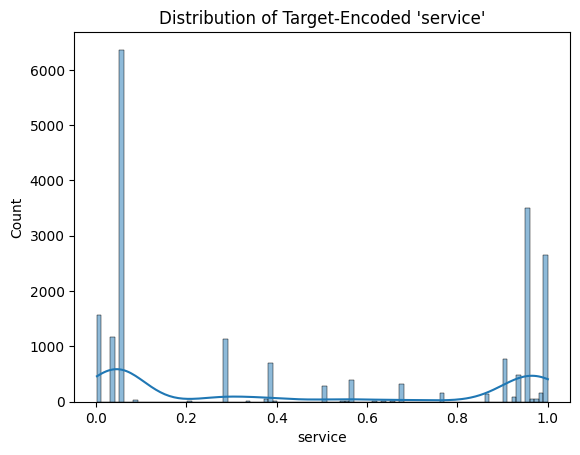

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(x_val_train['service'], bins=100, kde=True)
plt.title("Distribution of Target-Encoded 'service'")
plt.show()

Majority of Services almost always relate to normal or abnormal traffic

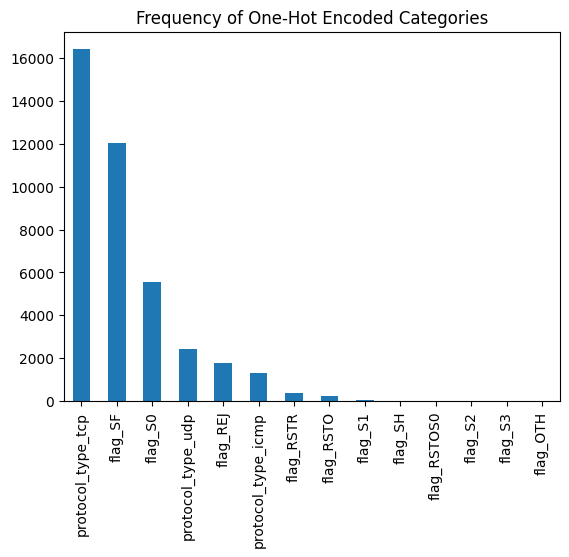

In [5]:
one_hot_cols_new=[col for col in x_val_train.columns if 'protocol_type' in col or 'flag' in col]
x_val_train[one_hot_cols_new].sum().sort_values(ascending=False).plot(kind='bar')
plt.title("Frequency of One-Hot Encoded Categories")
plt.show()

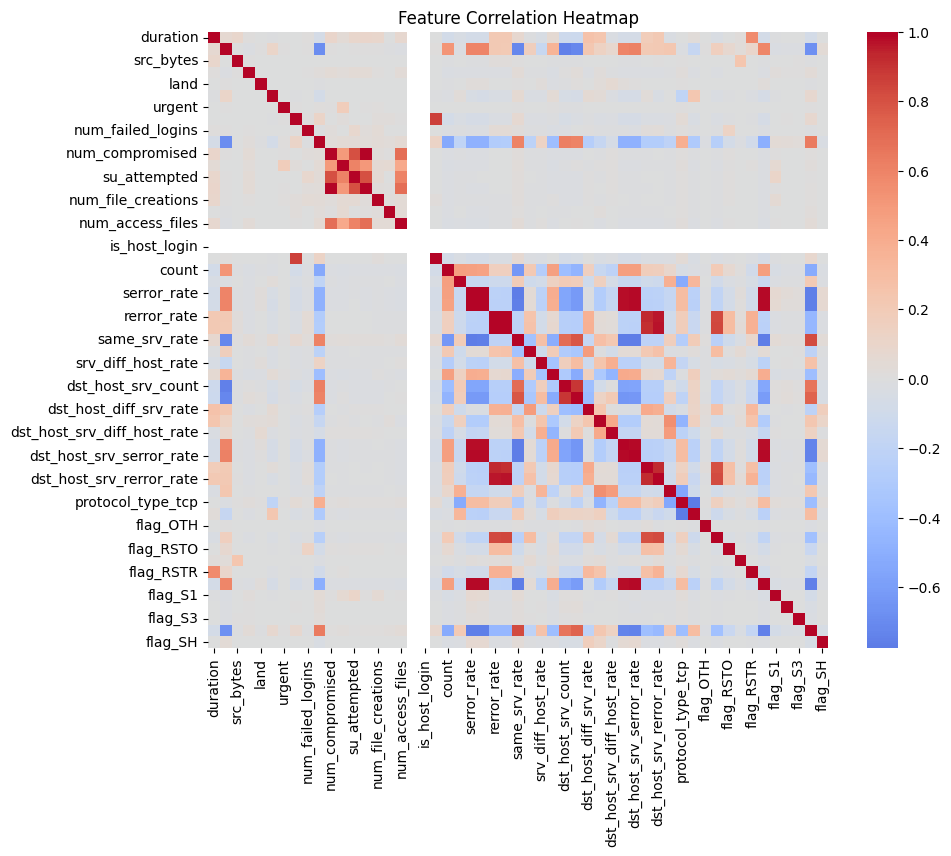

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(x_val_train.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


In [7]:
constant_cols_val_train=[col for col in x_val_train.columns if x_val_train[col].nunique() == 1]
constant_cols_val_test =[col for col in x_val_test.columns if x_val_test[col].nunique() == 1]
constant_cols_test =[col for col in x_test.columns if x_test[col].nunique() == 1]
print(constant_cols_val_train,constant_cols_val_test ,constant_cols_test)
# Drop 
x_val_train=x_val_train.drop(columns=constant_cols_val_train)
x_val_test= x_val_test.drop(columns=constant_cols_val_train, errors='ignore')
x_test= x_test.drop(columns=constant_cols_val_train, errors='ignore')

print(x_val_test.head())


['num_outbound_cmds', 'is_host_login'] ['land', 'urgent', 'num_outbound_cmds', 'is_host_login', 'flag_OTH'] ['num_outbound_cmds']
       duration   service  src_bytes  dst_bytes  land  wrong_fragment  urgent  \
19064         0  0.933610       1032          0     0               0       0   
11127         0  0.055006          0          0     0               0       0   
6517          0  0.954664          0          0     0               0       0   
2973          0  0.002034         45        114     0               0       0   
13339         0  0.055006          0          0     0               0       0   

       hot  num_failed_logins  logged_in  ...  flag_REJ  flag_RSTO  \
19064    0                  0          0  ...     False      False   
11127    0                  0          0  ...      True      False   
6517     0                  0          0  ...     False      False   
2973     0                  0          0  ...     False      False   
13339    0                  0    

In [8]:
x_val_train=x_val_train.astype(float)
x_val_test=x_val_test.astype(float)
x_test=x_test.astype(float)

print(x_val_train.head())
print(x_val_train.columns)

scaler=StandardScaler()
x_val_train_scaled=pd.DataFrame(scaler.fit_transform(x_val_train),columns=x_val_train.columns,index=x_val_train.index)
x_val_test_scaled=pd.DataFrame(scaler.transform(x_val_test),columns=x_val_test.columns,index=x_val_test.index)
x_test_scaled=pd.DataFrame(scaler.transform(x_test),columns=x_test.columns,index=x_test.index)

print(x_val_train_scaled.head())
print(x_val_test_scaled.head())
print(y_val_test)

       duration   service  src_bytes  dst_bytes  land  wrong_fragment  urgent  \
2199        0.0  0.903138        8.0        0.0   0.0             0.0     0.0   
15288       0.0  0.954664        0.0        0.0   0.0             0.0     0.0   
4139        0.0  0.386397    16787.0        0.0   0.0             0.0     0.0   
3505        0.0  0.954664        0.0        0.0   0.0             0.0     0.0   
19281       0.0  0.999946        0.0        0.0   0.0             0.0     0.0   

       hot  num_failed_logins  logged_in  ...  flag_REJ  flag_RSTO  \
2199   0.0                0.0        0.0  ...       0.0        0.0   
15288  0.0                0.0        0.0  ...       0.0        0.0   
4139   0.0                0.0        0.0  ...       0.0        0.0   
3505   0.0                0.0        0.0  ...       0.0        0.0   
19281  0.0                0.0        0.0  ...       0.0        0.0   

       flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  \
2199          

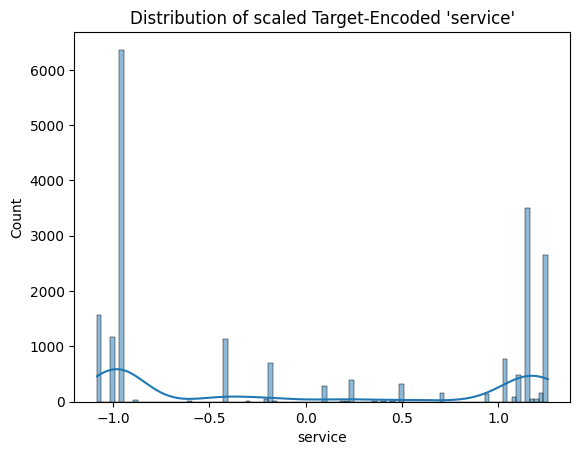

In [9]:
sns.histplot(x_val_train_scaled['service'], bins=100, kde=True)
plt.title("Distribution of scaled Target-Encoded 'service'")
plt.show()

MLP first train

In [10]:
mlp =MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500, random_state=42)
mlp.fit(x_val_train_scaled, y_val_train)

,hidden_layer_sizes,"(50, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True
,random_state,42


In [11]:
accuracy=mlp.score(x_val_test_scaled, y_val_test)
print("Validation Accuracy:", round(accuracy, 4))


Validation Accuracy: 0.9956


In [12]:
from sklearn.metrics import confusion_matrix, classification_report

y_val_pred=mlp.predict(x_val_test_scaled)

# Confusion matrix
cm=confusion_matrix(y_val_test, y_val_pred)
print("Confusion Matrix:\n", cm)

# Detailed report
print(classification_report(y_val_test, y_val_pred))


Confusion Matrix:
 [[2663   11]
 [  11 2354]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2674
           1       1.00      1.00      1.00      2365

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



In [13]:
y_val_prob=mlp.predict_proba(x_val_test_scaled)
from sklearn.metrics import log_loss
loss = log_loss(y_val_test, y_val_prob)
print("Log Loss:", round(loss, 4))


Log Loss: 0.0237


Permutation Importance

In [14]:
from sklearn.inspection import permutation_importance

x_sample=x_val_test_scaled.sample(n=5000, random_state=42)   # or smaller
y_sample=y_val_test.loc[x_sample.index]

result=permutation_importance(mlp, x_sample, y_sample, n_repeats=10, scoring='f1', random_state=42, n_jobs=-1)


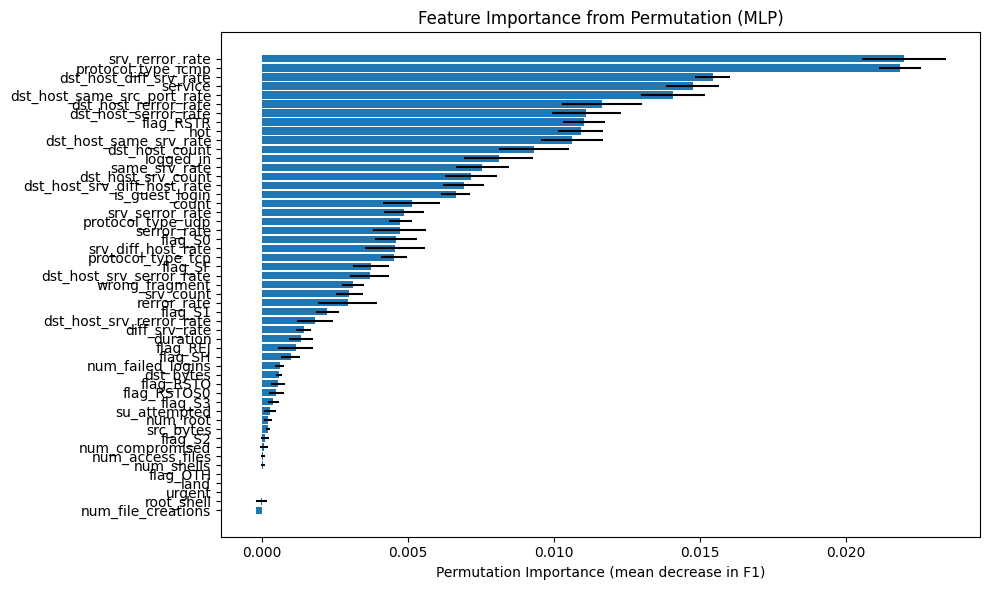

In [15]:
import numpy as np

# Convert results into a sorted order by mean importance
sorted_idx=result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(
    np.array(x_sample.columns)[sorted_idx],       #feature names
    result.importances_mean[sorted_idx],          #mean importance
    xerr=result.importances_std[sorted_idx],      #error bars = variability
    align='center'
)
plt.xlabel("Permutation Importance (mean decrease in F1)")
plt.title("Feature Importance from Permutation (MLP)")
plt.tight_layout()
plt.show()


Permutation importance using f1 score. Purpose is to minimize input but keep the accuracy high and errors low, by keeping the columns (important features) that have an f1 test score mean above the threshold

In [16]:
threshold =0.007

# Get important feature names
important_features=x_sample.columns[result.importances_mean> threshold]

print(len(important_features) , important_features)


14 Index(['service', 'hot', 'logged_in', 'srv_rerror_rate', 'same_srv_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_serror_rate', 'dst_host_rerror_rate', 'protocol_type_icmp',
       'flag_RSTR'],
      dtype='object')


In [17]:
x_val_train_scaled=x_val_train_scaled[important_features]
x_val_test_scaled=x_val_test_scaled[important_features]
x_test_scaled=x_test_scaled[important_features]
print(x_val_train_scaled.info)

mlp = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500, random_state=42)
mlp.fit(x_val_train_scaled, y_val_train)


accuracy=mlp.score(x_val_test_scaled, y_val_test)
print("Validation Accuracy:", round(accuracy, 4))


<bound method DataFrame.info of         service       hot  logged_in  srv_rerror_rate  same_srv_rate  \
2199   1.029526 -0.093748  -0.805969        -0.374272       0.770588   
15288  1.150355 -0.093748  -0.805969        -0.374272      -1.210797   
4139  -0.182234 -0.093748  -0.805969        -0.374272      -1.301896   
3505   1.150355 -0.093748  -0.805969        -0.374272      -1.392994   
19281  1.256542 -0.093748  -0.805969        -0.374272      -1.096925   
...         ...       ...        ...              ...            ...   
21575 -1.083566 -0.093748  -0.805969        -0.374272       0.770588   
5390  -0.998527 -0.093748   1.240742        -0.374272       0.770588   
860   -0.959347 -0.093748  -0.805969         2.722484      -1.461317   
15795 -0.959347 -0.093748   1.240742        -0.374272       0.770588   
23654  1.150355 -0.093748  -0.805969        -0.374272      -1.370219   

       dst_host_count  dst_host_srv_count  dst_host_same_srv_rate  \
2199        -1.836238            0

In [18]:
y_val_prob=mlp.predict_proba(x_val_test_scaled)
from sklearn.metrics import log_loss
loss = log_loss(y_val_test, y_val_prob)
print("Log Loss:", round(loss, 4))

Log Loss: 0.0341


At 14 input columns we have log loss=0.03 and accuracy still at 0.99

In [19]:
y_pred_test = mlp.predict(x_test_scaled)

In [20]:
y_pred_test = pd.DataFrame(y_pred_test, columns=['predicted_class'])

print(y_pred_test.head(), x_test_scaled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   service                      22544 non-null  float64
 1   hot                          22544 non-null  float64
 2   logged_in                    22544 non-null  float64
 3   srv_rerror_rate              22544 non-null  float64
 4   same_srv_rate                22544 non-null  float64
 5   dst_host_count               22544 non-null  float64
 6   dst_host_srv_count           22544 non-null  float64
 7   dst_host_same_srv_rate       22544 non-null  float64
 8   dst_host_diff_srv_rate       22544 non-null  float64
 9   dst_host_same_src_port_rate  22544 non-null  float64
 10  dst_host_serror_rate         22544 non-null  float64
 11  dst_host_rerror_rate         22544 non-null  float64
 12  protocol_type_icmp           22544 non-null  float64
 13  flag_RSTR       

In [21]:
import joblib
import os

os.makedirs("models", exist_ok=True)

model_package = {
    "mlp_model": mlp,
    "target_encoder": te,
    "columns": x_val_train.columns,
    "scaler": scaler,
    "dropped_columns": constant_cols_val_train
}

# Save model and preprocessing components
joblib.dump(model_package, "models/mlp_model.joblib")

['models/mlp_model.joblib']

Random Forest prediction on the same data, unscaled

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(
    n_estimators=200,  
    max_depth=None,        
    min_samples_split=2,    
    min_samples_leaf=1,      
    max_features='sqrt',     
    random_state=42,
    n_jobs=-1                
)

rf.fit(x_val_train, y_val_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
x_sample_rf=x_val_test.sample(n=5000, random_state=42)   # or smaller
y_sample_rf=y_val_test.loc[x_sample_rf.index]

result=permutation_importance(rf, x_sample_rf, y_sample_rf, n_repeats=10, scoring='f1', random_state=42, n_jobs=-1)


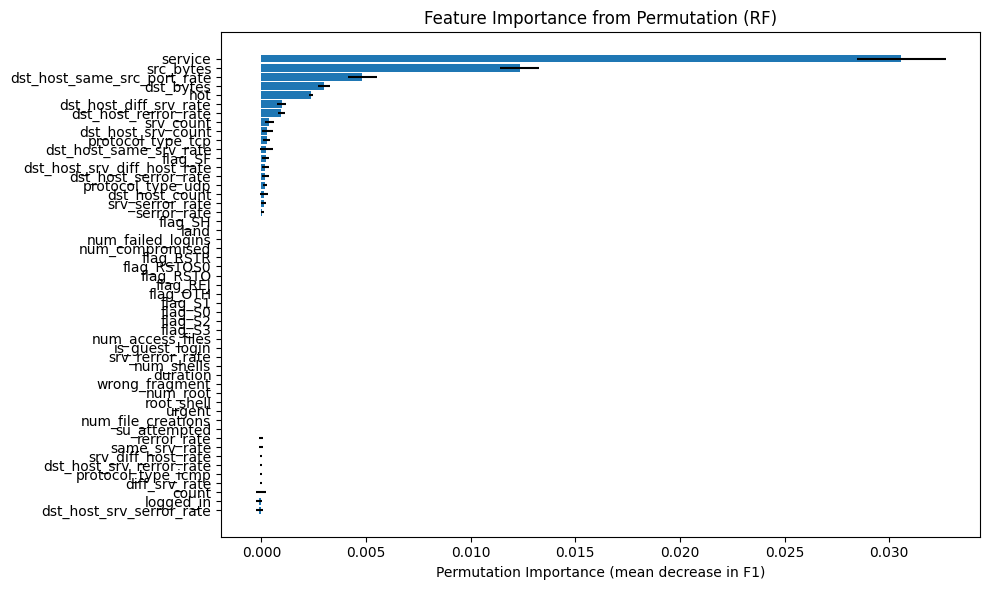

In [24]:
sorted_idx=result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(
    np.array(x_sample_rf.columns)[sorted_idx],       #feature names
    result.importances_mean[sorted_idx],          #mean importance
    xerr=result.importances_std[sorted_idx],      #error bars = variability
    align='center'
)
plt.xlabel("Permutation Importance (mean decrease in F1)")
plt.title("Feature Importance from Permutation (RF)")
plt.tight_layout()
plt.show()

In [25]:
idx=list(x_sample_rf.columns).index('srv_count')
print(result.importances_mean[idx])

threshold =0.0003841409914572824

# Get important feature names
important_features=x_sample.columns[result.importances_mean> threshold]

print(len(important_features) , important_features)


0.0003841409914572824
7 Index(['service', 'src_bytes', 'dst_bytes', 'hot', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_rerror_rate'],
      dtype='object')


In [26]:
from sklearn.metrics import accuracy_score,f1_score
y_pred=rf.predict(x_val_test)
y_prob=rf.predict_proba(x_val_test)
y_train_prob=rf.predict_proba(x_val_train)
y_train_pred=rf.predict(x_val_train)

print("VAL with all of the features:")
print("Accuracy:", accuracy_score(y_val_test, y_pred))

print("Log Loss:", log_loss(y_val_test, y_prob))

print("F1 Score:", f1_score(y_val_test, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_val_test, y_pred))

print(classification_report(y_val_test, y_pred))
print(len(x_val_test.columns))
print(x_val_test.head())


print("TRAIN:")
print("Accuracy:", accuracy_score(y_val_train, y_train_pred))
print("Log Loss:", log_loss(y_val_train, y_train_prob))


VAL with all of the features:
Accuracy: 0.9978170271879341
Log Loss: 0.009273395980877697
F1 Score: 0.9976719576719577
Confusion Matrix:
 [[2671    3]
 [   8 2357]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2674
           1       1.00      1.00      1.00      2365

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039

51
       duration   service  src_bytes  dst_bytes  land  wrong_fragment  urgent  \
19064       0.0  0.933610     1032.0        0.0   0.0             0.0     0.0   
11127       0.0  0.055006        0.0        0.0   0.0             0.0     0.0   
6517        0.0  0.954664        0.0        0.0   0.0             0.0     0.0   
2973        0.0  0.002034       45.0      114.0   0.0             0.0     0.0   
13339       0.0  0.055006        0.0        0.0   0.0             0.0     0.0   

       hot  num_fa

In [27]:
x_val_train_rf=x_val_train[important_features]
x_val_test_rf=x_val_test[important_features]
x_test_rf=x_test[important_features]


rf=RandomForestClassifier(
    n_estimators=200,  
    max_depth=None,        
    min_samples_split=2,    
    min_samples_leaf=1,      
    max_features='sqrt',     
    random_state=42,
    n_jobs=-1                
)

rf.fit(x_val_train_rf, y_val_train)


y_pred=rf.predict(x_val_test_rf)
y_prob=rf.predict_proba(x_val_test_rf)
y_train_prob=rf.predict_proba(x_val_train_rf)
y_train_pred=rf.predict(x_val_train_rf)

print("VALIDATION using the 7 most important features:")
print("Accuracy:", accuracy_score(y_val_test, y_pred))

print("Log Loss:", log_loss(y_val_test, y_prob))

print("F1 Score:", f1_score(y_val_test, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_val_test, y_pred))

print(classification_report(y_val_test, y_pred))
print(len(x_val_test_rf.columns))
print(x_val_test_rf.head())

VALIDATION using the 7 most important features:
Accuracy: 0.9972216709664616
Log Loss: 0.024426160557789563
F1 Score: 0.9970401691331924
Confusion Matrix:
 [[2667    7]
 [   7 2358]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2674
           1       1.00      1.00      1.00      2365

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039

7
        service  src_bytes  dst_bytes  hot  dst_host_diff_srv_rate  \
19064  0.933610     1032.0        0.0  0.0                    0.00   
11127  0.055006        0.0        0.0  0.0                    0.00   
6517   0.954664        0.0        0.0  0.0                    0.06   
2973   0.002034       45.0      114.0  0.0                    0.11   
13339  0.055006        0.0        0.0  0.0                    0.00   

       dst_host_same_src_port_rate  dst_host_rerror_rate  
19064   

In [28]:
model_package_rf = {
    "rf_model": rf,
    "target_encoder": te,
    "columns": x_val_train.columns,
    "dropped_columns": constant_cols_val_train
}

# Save model and preprocessing components
joblib.dump(model_package_rf, "models/rf_model.joblib")

['models/rf_model.joblib']